Nous examinerons toutes les caractéristiques et en sélectionnerons cinq pour créer des clusters. Après avoir construit notre modèle et choisi un nombre approprié de clusters, nous apprendrons à visualiser les clusters multidimensionnelles dans un diagramme de dispersion 2D à l'aide d'une méthode appelée analyse en composantes principales (ACP).

In [45]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
from IPython.display import VimeoVideo
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Prepare data

L'un des problèmes persistants que nous avons rencontrés avec cet ensemble de données est qu'il comprend quelques valeurs aberrantes sous la forme de ménages ultra-riches. Cela n'a pas fait une grande différence pour notre dernière analyse, mais cela pourrait poser un problème maintenant, c'est pourquoi nous allons nous concentrer sur les familles dont la valeur nette est inférieure à 2 millions de dollars.

In [10]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    mask = (df["TURNFEAR"])&(df["NETWORTH"]<2e6)
    df = df[mask]
    return df

In [11]:
df = wrangle("data/SCFP2019.csv")

In [12]:
df.shape

(4418, 351)

Pour choisir les meilleurs variable pour notre clustering nous allons choisir les variables ayant les plus  grandes variances

In [19]:
top_10_high_var = df.var().sort_values().tail(10)

Il serait plus judicieux que nous creons un graphique pour mieux voir

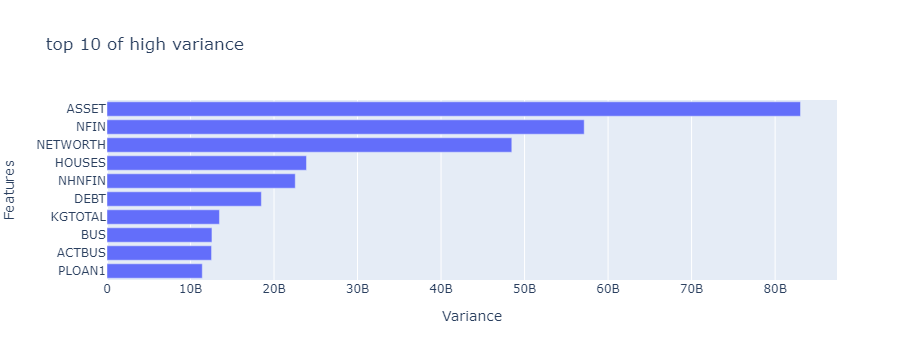

In [22]:
fig = px.bar(
    x=top_10_high_var,
    y=top_10_high_var.index,
    title="top 10 of high variance"
)
fig.update_layout(xaxis_title="Variance", yaxis_title="Features")
fig.show()

Tout au long de ce projet, nous avons constaté que de nombreux indicateurs de richesse sont fortement asymétriques, avec quelques ménages aberrants disposant d'une richesse énorme. Ces valeurs aberrantes peuvent affecter notre mesure de la variance. Voyons si c'est le cas avec l'une des caractéristiques de top_five_var.

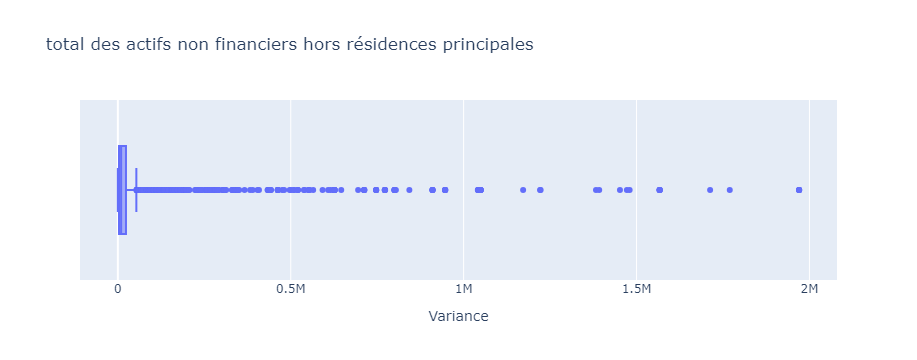

In [25]:
fig = px.box(
    x=df["NHNFIN"],
    title="total des actifs non financiers hors résidences principales"
)
fig.update_layout(xaxis_title="Variance")
fig.show()

Ouah ! L'ensemble de données est massivement asymétrique à droite en raison des énormes valeurs aberrantes du côté droit de la distribution. Même si nous avons déjà exclu les ménages disposant d'une valeur nette élevée à l'aide de notre fonction wrangle, la variance est encore faussée par certaines valeurs aberrantes extrêmes.

La meilleure façon d'y remédier est d'examiner la variance tronquée, qui consiste à supprimer les valeurs extrêmes avant de calculer la variance. Pour ce faire, nous utilisons la fonction trimmed_var de la bibliothèque SciPy.

In [28]:
df.apply(trimmed_var, limits=(0.1, 0.1)).sort_values().tail(10)

WAGEINC     5.550737e+08
HOMEEQ      7.338377e+08
NH_MORT     1.333125e+09
MRTHEL      1.380468e+09
PLOAN1      1.441968e+09
DEBT        3.089865e+09
NETWORTH    3.099929e+09
HOUSES      4.978660e+09
NFIN        8.456442e+09
ASSET       1.175370e+10
dtype: float64

In [29]:
top_ten_trim_var = df.apply(trimmed_var, limits=(0.1, 0.1)).sort_values().tail(10)

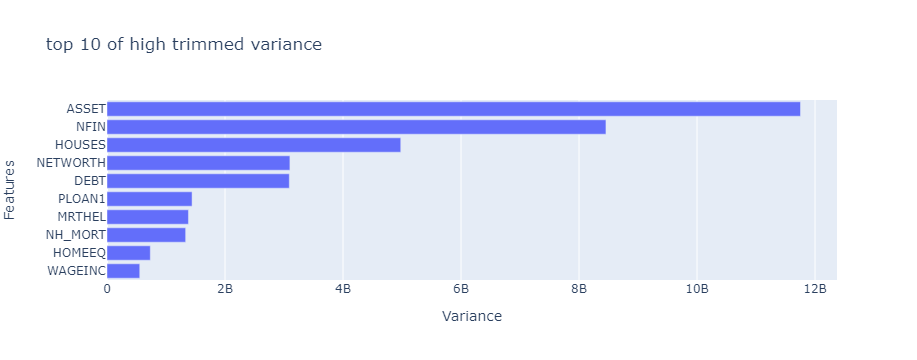

In [31]:
fig = px.bar(
    x=top_ten_trim_var,
    y=top_ten_trim_var.index,
    title="top 10 of high trimmed variance"
)
fig.update_layout(xaxis_title="Variance", yaxis_title="Features")
fig.show()

Il y a trois choses à remarquer dans ce graphique. Premièrement, les écarts ont beaucoup diminué. Dans notre graphique précédent, l'axe des abscisses allait jusqu'à 80 milliards de dollars ; ici, il va jusqu'à 12 milliards de dollars. Deuxièmement, les dix principales caractéristiques ont quelque peu changé. Toutes les caractéristiques relatives à la propriété des entreprises ("...BUS") ont disparu. Enfin, nous pouvons constater qu'il existe de grandes différences de variance d'une caractéristique à l'autre. Par exemple, la variance pour "WAGEINC" est d'environ 500 millions de dollars, alors que la variance pour "ASSET" est de près de 12 milliards de dollars. En d'autres termes, ces caractéristiques ont des échelles complètement différentes. C'est un problème que nous devrons résoudre avant de pouvoir créer de bonnes grappes.

In [38]:
high_var = top_ten_trim_var.tail(5).index.to_list()

In [39]:
high_var

['DEBT', 'NETWORTH', 'HOUSES', 'NFIN', 'ASSET']

### Split

In [40]:
X = df[high_var]

In [42]:
X.head()

,DEBT,NETWORTH,HOUSES,NFIN,ASSET
5,12200.0,-6710.0,0.0,3900.0,5490.0
6,12600.0,-4710.0,0.0,6300.0,7890.0
7,15300.0,-8115.0,0.0,5600.0,7185.0
8,14100.0,-2510.0,0.0,10000.0,11590.0
9,15400.0,-5715.0,0.0,8100.0,9685.0


In [43]:
X.shape

(4418, 5)

## Build Model

In [47]:
n_clusters = range(3, 13)
inertia_errors = []
silhouette_scores = []

for k in n_clusters:
    #build model
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    model.fit(X)
    #calculate enertia
    inertia_errors.append(model.named_steps['kmeans'].inertia_)
    #calculate silhouette_score
    silhouette_scores.append(silhouette_score(X, model.named_steps["kmeans"].labels_))

print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [7190.526303575349, 5924.997726868024, 5007.534391765885]

Silhouette Scores: [0.7044601307791996, 0.6962653079183132, 0.6596375627049622]


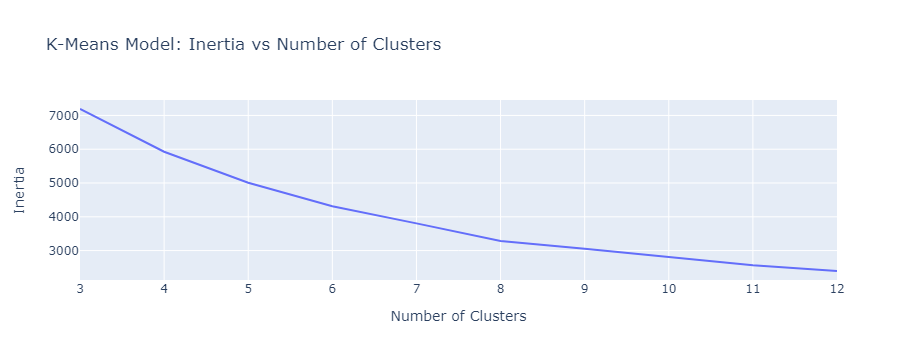

In [48]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
    x=n_clusters, 
    y=inertia_errors,
    title="K-Means Model: Inertia vs Number of Clusters"
)
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Inertia")
fig.show()

Vous pouvez voir que la ligne commence à s'aplatir autour de 4 ou 5 clusters.

Réalisons un autre graphique linéaire basé sur les scores de la silhouette.

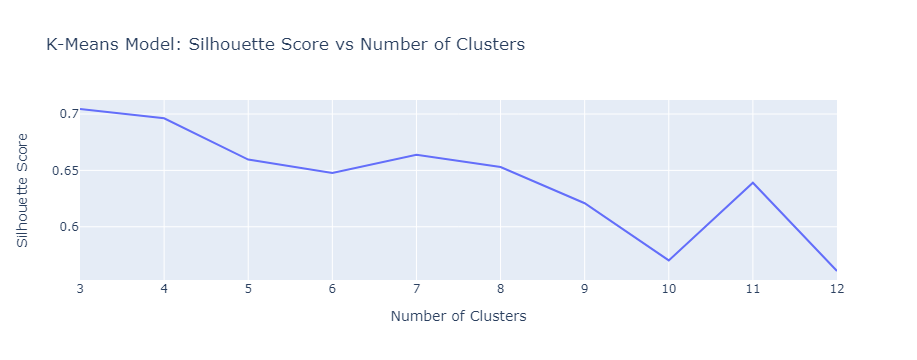

In [49]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(
    x=n_clusters, y=silhouette_scores, title="K-Means Model: Silhouette Score vs Number of Clusters"
)
fig.update_layout(
    xaxis_title="Number of Clusters", yaxis_title="Silhouette Score"
)
fig.show()

Celui-ci est un peu moins simple, mais nous pouvons voir que les meilleurs scores de silhouette se produisent lorsqu'il y a 3 ou 4 clusters.

En combinant les informations de ce graphique avec notre graphique d'inertie, il semble que le meilleur paramètre pour n_clusters soit 4

In [50]:
final_model = make_pipeline(StandardScaler(), KMeans(n_clusters=4, random_state=42))
final_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

## Communicate

In [51]:
labels = final_model.named_steps['kmeans'].labels_

In [52]:
print(labels[:5])

[0 0 0 0 0]


Nous allons réaliser une visualisation, nous devons donc créer un nouveau DataFrame avec lequel nous allons travailler

In [53]:
xgb = X.groupby(labels).mean()

In [54]:
xgb

,DEBT,NETWORTH,HOUSES,NFIN,ASSET
0,26551.075439,13676.153182,13745.637777,2.722605e+04,4.022723e+04
1,218112.818182,174713.441558,257403.246753,3.305884e+05,3.928263e+05
2,116160.779817,965764.155963,264339.449541,7.800611e+05,1.081925e+06
3,732937.575758,760397.575758,826136.363636,1.276227e+06,1.493335e+06


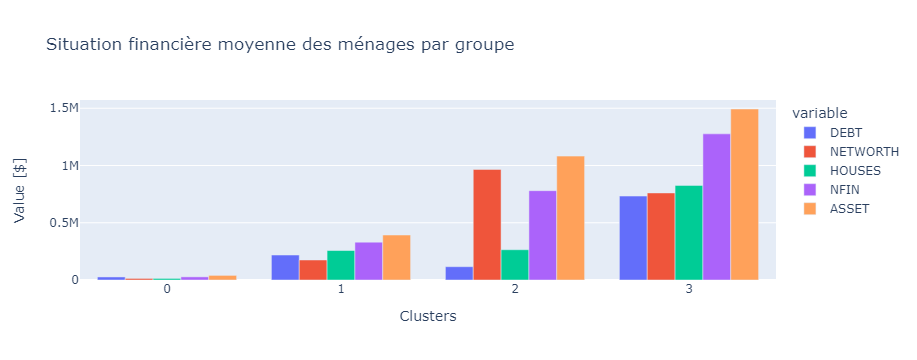

In [56]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(
    xgb,
    barmode="group",
    title="Situation financière moyenne des ménages par groupe"
    
)
fig.update_layout(
    xaxis_title="Clusters", yaxis_title="Value [$]"
)
fig.show()

N'oubliez pas que nos groupes sont basés en partie sur le NETWORTH, ce qui signifie que les ménages du groupe 0 ont la valeur nette la plus faible et que les ménages du groupe 2 ont la valeur nette la plus élevée. Sur cette base, il y a quelques éléments intéressants à analyser.

Tout d'abord, examinons la variable DETTE. On pourrait penser qu'elle augmente avec la valeur nette, mais ce n'est pas le cas. Ce sont les ménages du groupe 2 qui ont le plus faible niveau d'endettement, même si la valeur de leur maison (en vert) est à peu près la même. Ces données ne permettent pas vraiment de comprendre ce qui se passe, mais il est possible que les personnes du groupe 2 aient suffisamment d'argent pour rembourser leurs dettes, mais pas assez pour s'endetter davantage avec l'effet de levier de ce qu'elles possèdent. Les personnes du groupe 3, en revanche, n'ont peut-être pas besoin de s'inquiéter de leur endettement en raison de leur valeur nette élevée.

Enfin, puisque nous avons commencé ce projet en étudiant la valeur des maisons, examinons la relation entre l'ENDETTEMENT et les MAISONS. La valeur de la dette des personnes du groupe 0 est supérieure à la valeur de leur logement, ce qui suggère que la majeure partie de la dette de ces personnes est liée à leur hypothèque - si tant est qu'elles soient propriétaires d'un logement. En revanche, dans les trois autres groupes, la valeur de la dette de tous les autres est inférieure à la valeur de leur logement.

Tout cela est assez intéressant, mais c'est différent de ce que nous avons fait la dernière fois, n'est-ce pas ? À ce stade de la dernière leçon, nous avons réalisé un diagramme de dispersion. Il s'agissait d'une tâche simple, car nous n'avions travaillé qu'avec deux caractéristiques, de sorte que nous pouvions représenter les points de données en deux dimensions. Mais maintenant, X a cinq dimensions ! Comment pouvons-nous tracer ce diagramme pour donner aux parties prenantes une idée de nos grappes ?

Comme nous travaillons sur un écran d'ordinateur, nous n'avons pas beaucoup de choix quant au nombre de dimensions que nous pouvons utiliser : il doit être de deux. Par conséquent, si nous voulons faire quelque chose comme le diagramme de dispersion que nous avons fait précédemment, nous devrons prendre nos données à 5 dimensions et les transformer en quelque chose que nous pourrons regarder en 2 dimensions.

In [57]:
# Instantiate transformer
pca = PCA(n_components=2, random_state=42 )

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=["PC1", "PC2"])
print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (4418, 2)


,PC1,PC2
0,-221525.424530,-22052.273003
1,-217775.100722,-22851.358068
2,-219519.642175,-19023.646333
3,-212195.720367,-22957.107039
4,-215540.507551,-20259.749306


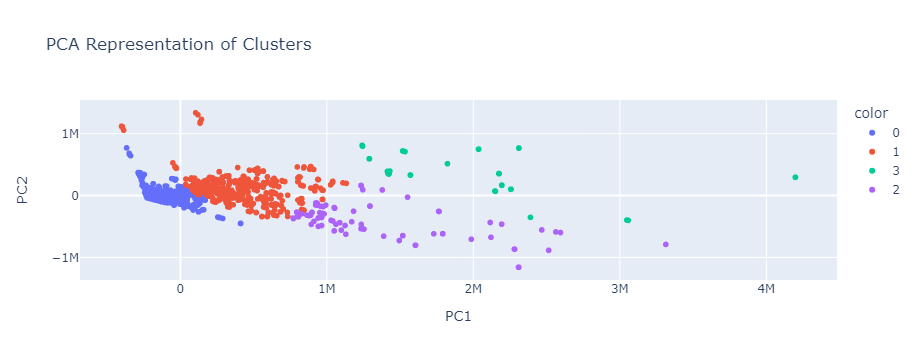

In [58]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(
    x=X_pca["PC1"],
    y=X_pca["PC2"],
    color=labels.astype(str),
    title="PCA Representation of Clusters"
    
    
)
fig.update_layout(
    xaxis_title="PC1", yaxis_title="PC2"
)

fig.show()

L'une des limites de ce graphique est qu'il est difficile d'expliquer ce que les axes représentent. En fait, les deux axes sont une combinaison des cinq caractéristiques que nous avions à l'origine dans X, ce qui signifie que c'est assez abstrait. Néanmoins, c'est le meilleur moyen dont nous disposons pour montrer autant d'informations que possible en tant qu'outil explicatif pour les personnes qui ne font pas partie de la communauté de la science des données.

Que signifie donc ce graphique ? Il signifie que nous avons créé quatre groupes étroitement groupés qui partagent certaines caractéristiques clés. Si nous devions présenter cela à un groupe de parties prenantes, il pourrait être utile de montrer d'abord ce graphique comme une sorte d'échauffement, puisque la plupart des gens comprennent le fonctionnement d'un objet bidimensionnel. Nous pourrions ensuite passer à une analyse plus nuancée des données.

Il s'agit là d'un élément à garder à l'esprit tout au long de votre parcours dans le domaine de la science des données